<a href="https://colab.research.google.com/github/CodeByHarri/blog/blob/master/_notebooks/2021-08-09-Order-Book-Spread-A-Support-and-Resistence-Story.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Order Book Spread, A Support and Resistence Story
> Can the order book tell us future entry/exit points?

- toc: false
- badges: false
- comments: true
- categories: [Blockchain]
- image: images/chart-preview.png

In [97]:
#hide
#@title Imports

import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go
import requests
import datetime

import numpy as np
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgb, to_rgba
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
import random
sns.set()
!pip install mplfinance
# More Plotting libaries 
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.pylab import date2num
from dateutil.relativedelta import relativedelta

epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

!pip install yfinance
import yfinance as yf

In [98]:
#hide
#@title data
def data(tick,p=182,kk=False):
  """
  Give a ticker and period in days, the VPVR is plotted and resistant lines are shown
  """

  ### Data functions
  if (kk==False):
    ticker = yf.Ticker(tick)
    df = ticker.history(period='max',interval='1d')
    cp = df.Close[len(df)-1]
  elif (kk==True):
    link = f'https://openapi-v2.kucoin.com/api/v3/market/orderbook/level2?symbol={tick}'
    r = requests.get(link)	
    df = pd.DataFrame.from_records(r.json()['data'])
    df.columns = ['Time', 'Open', 'Close', 'High', 'Low', 'Volume', 'Turnover']
    df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')
    df = df.set_index('Time')
    df = df.head(p) 
    for col in df.columns:
      df[col] = pd.to_numeric(df[col])
    cp = df.Close[0]
  
  return df

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [99]:
#hide
#@title spread

def spread(tick,l=5000):
  # data for left plot
  r = requests.get("https://api.binance.com/api/v3/depth",
                  params=dict(symbol=tick,limit=l))
  # Default 100; max 5000. Valid limits:[5, 10, 20, 50, 100, 500, 1000, 5000]
  results = r.json()
  frames = {side: pd.DataFrame(data=results[side], columns=["price", "quantity"],
                              dtype=float)
            for side in ["bids", "asks"]}
  frames_list = [frames[side].assign(side=side) for side in frames]
  df = pd.concat(frames_list, axis="index", 
                  ignore_index=True, sort=True)
  df['price'] = pd.to_numeric(df['price'])
  total_bids = df[df.side =='bids']['quantity'].sum()
  total_asks = df[df.side =='asks']['quantity'].sum()
  buying_pressure = (df.price.min()*total_bids)-(df.price.max()*total_asks)
  bids = df[df.side =='bids']
  asks = df[df.side =='asks']
  bids['cumsum'] = bids['quantity'].cumsum()
  bids['cumsum_norm'] = [round(x,2) for x in NormalizeData(bids['cumsum'].values)]
  asks['cumsum'] = asks['quantity'].cumsum()
  asks['cumsum_norm'] = [round(x,2) for x in NormalizeData(asks['cumsum'].values)]
  df = pd.concat([bids,asks])
  minbid = bids.groupby(['cumsum_norm']).min().reset_index().sort_values('price')
  maxbid = bids.groupby(['cumsum_norm']).max().reset_index().sort_values('price')
  minask = asks.groupby(['cumsum_norm']).min().reset_index().sort_values('price')
  maxask = asks.groupby(['cumsum_norm']).max().reset_index().sort_values('price')
  # print(minbid.tail(50))
  # data for right plot
  url = 'https://api.binance.com/api/v3/klines'
  params = {
    'symbol': tick,
    'interval': '1h',
    'startTime' : round(unix_time_millis(datetime.datetime.now() - datetime.timedelta(minutes=12000))) #2 hours ago
  }
  r = requests.get(url, params=params)
  results = r.json()
  prices = pd.DataFrame.from_records(results)
  prices.columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore.']
  prices['Open time'] = pd.to_datetime(prices['Open time'], unit='ms', errors='coerce')
  prices = prices.set_index('Open time')
  prices['Close'] = pd.to_numeric(prices['Close'])
  # prices = prices.tail(120)
  

  # plot
  sns.set_style("whitegrid")
  plt.style.use('seaborn-dark-palette')
  f, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5),
                               gridspec_kw={'width_ratios': [1, 2.5]}, dpi= 100, 
                               sharey=True)

  # left plot
  # Modified so that price is y and quantity is x
  ax1.set_title(f"{tick} SPREAD at {datetime.datetime.now()}")
  sns.ecdfplot(y="price", weights="quantity", stat="count", color='green',
               complementary=True, data=frames["bids"], ax=ax1)
  sns.ecdfplot(y="price", weights="quantity", stat="count",color='red',
               data=frames["asks"], ax=ax1)

  # sns.histplot(y="price", weights="quantity", hue="side", binwidth=0.02, bins=20, data=df, ax=ax1)

  sns.scatterplot(x="quantity", y="price", hue="side",palette=['green','red'], data=df, ax=ax1)
  ax1.set_xlabel("Quantity")
  ax1.set_yticks(df.price, minor=True)
  ax1.set_ylabel("Price")

  # right plot
  ax2.plot(prices.index, prices['Close'], alpha = 1)

  xmin, xmax = ax2.get_xlim()
  ymin, ymax = ax2.get_ylim()
  cmap = LinearSegmentedColormap.from_list('', ['white', 'red'])
  ax2.imshow(np.interp(np.linspace(minask.price.values[0], minask.price.values[-1], 100), minask.price.values, minask.cumsum_norm.values).reshape(-1, 1),
            cmap=cmap, vmin=0, vmax=1,
            extent=[xmin, xmax, minask.price.values[0], minask.price.values[-1]], origin='lower',
            interpolation='bilinear', aspect='auto', zorder=-1)
  ax2.set_xlim(xmin, xmax)
  ax2.set_ylim(ymin, ymax)

  xmin, xmax = ax2.get_xlim()
  ymin, ymax = ax2.get_ylim()
  cmap = LinearSegmentedColormap.from_list('', ['white', 'forestgreen'])
  ax2.imshow(np.interp(np.linspace(min(maxbid.price.values), max(maxbid.price.values), 100), maxbid.price.values, maxbid.cumsum_norm.values).reshape(-1, 1),
            cmap=cmap, vmin=0, vmax=1,
            extent=[xmin, xmax, min(maxbid.price.values), max(maxbid.price.values)], origin='lower',
            interpolation='bilinear', aspect='auto', zorder=-1)
  ax2.set_xlim(xmin, xmax)
  ax2.set_ylim(ymin, ymax)


  ax2.annotate(round(df.price.max(),2), (prices.index[0], df.price.max()))
  ax2.annotate(round(df.price.min(),2), (prices.index[0], df.price.min()))
  ax2.set_title(f"{tick} Asks - Bids is ${round(buying_pressure,2)}")
  ax2.set_xlabel('Date')

  # Share y-axis between subplots
  # if you want to merge axes values, uncomment this line
  # ax1.get_shared_y_axes().join(ax1, ax2)

  return plt.show()


{% include alert.html text="Roses are red, violets are blue. This is not financial advice, I genuinely have no clue." %}


### What am I looking at? 

The left graph shows the order book of a cryptocurrency listed on Binance. The x axis shows the cumaltive quantity of the asset and the y axis shows the price. This also reflected over the price vs time on the right graph. The darker reds show selling pressure and darker greens show buying pressure. 

### How is this useful?

This could be seen as an indicator into strong supports and resistances, for immediate or near future price entry. 




### 5000 data points deep into the order book

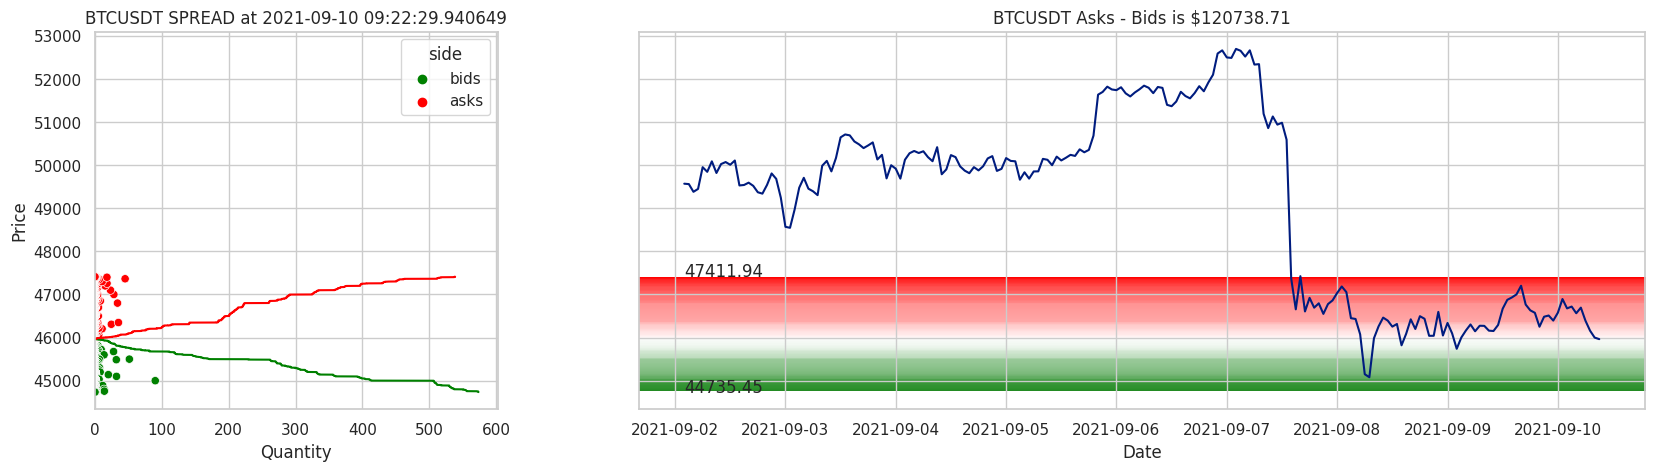

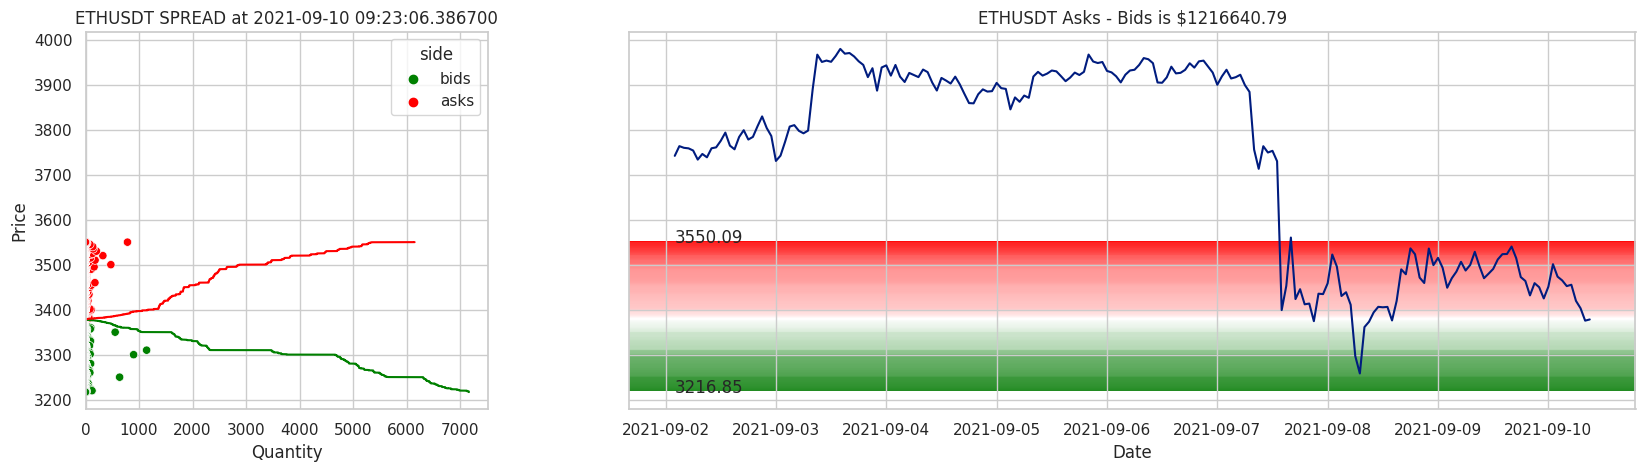

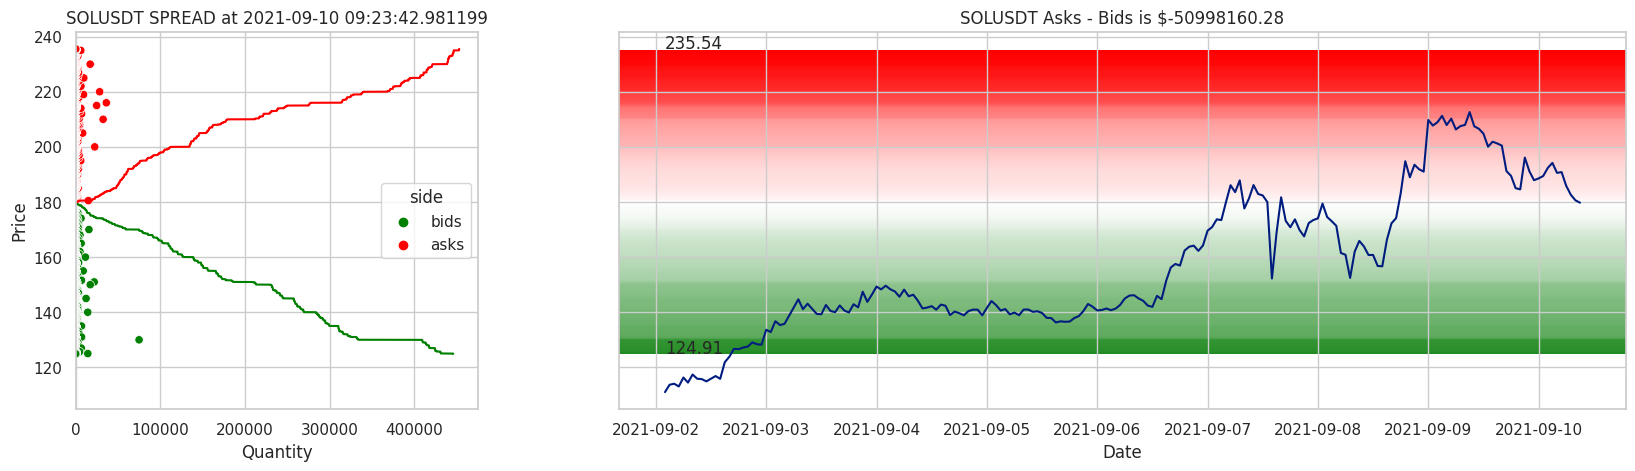

In [107]:
#hide_input
# _notebooks/2021-08-09-Order-Book-Spread-A-Support-and-Resistence-Story
pd.options.mode.chained_assignment = None
for x in ['BTCUSDT','ETHUSDT','SOLUSDT']:
  spread(x,5000)

### 1000 data points deep into the order book

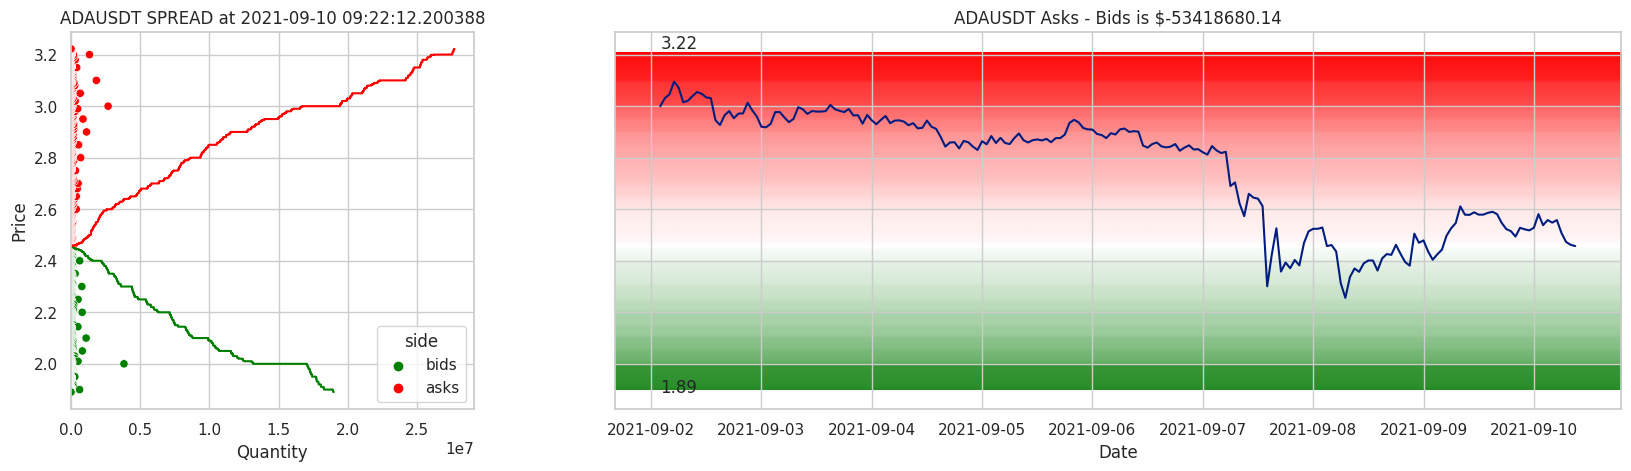

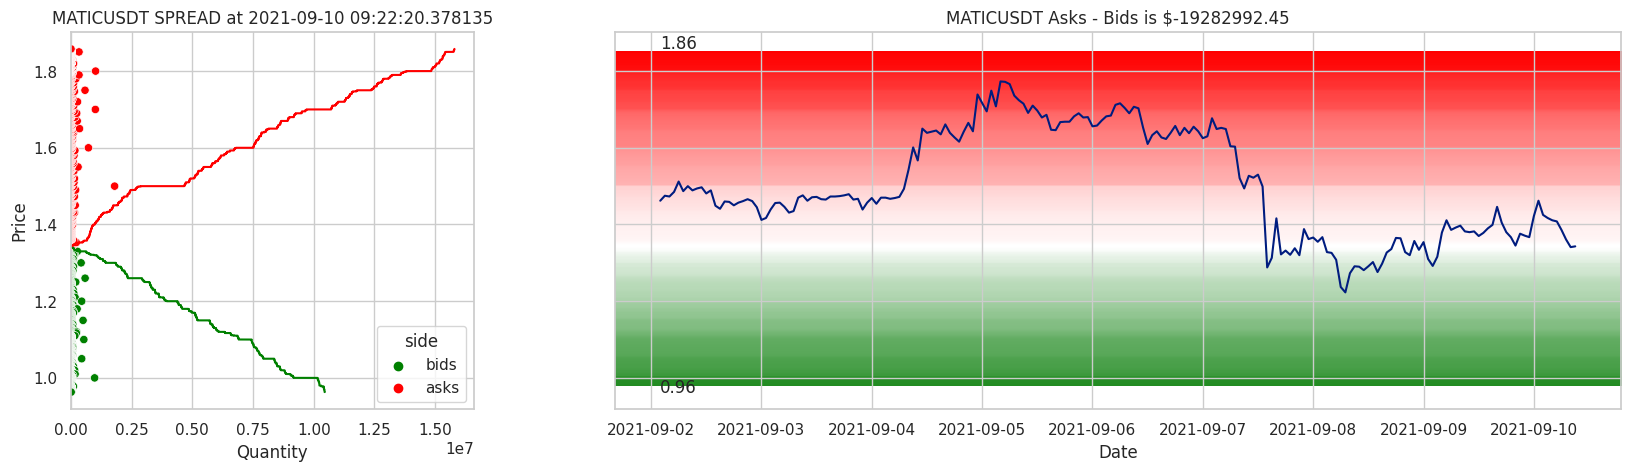

In [106]:
#hide_input
pd.options.mode.chained_assignment = None
for x in ['ADAUSDT','MATICUSDT']:
  spread(x,1000)

In [ ]:
#hide
# from IPython import display
# import time
# d = []
# b = []
# mn = []
# mx = []
# fig = plt.figure()
# fig.set_size_inches((25, 16)) 
# for i in range(1,100000):
#   # display.clear_output(wait=True)
#   # display.display(plt.gcf())
#   r = requests.get("https://api.binance.com/api/v3/depth",
#                   params=dict(symbol='BTCUSDT'))
#   results = r.json()
#   frames = {side: pd.DataFrame(data=results[side], columns=["price", "quantity"],
#                               dtype=float)
#             for side in ["bids", "asks"]}
#   frames_list = [frames[side].assign(side=side) for side in frames]
#   df = pd.concat(frames_list, axis="index", 
#                   ignore_index=True, sort=True)
#   total_bids = df[df.side =='bids']['quantity'].sum()
#   total_asks = df[df.side =='asks']['quantity'].sum()
#   mn.append(df.price.min())
#   mx.append(df.price.max())
#   buying_pressure = (df.price.min()*total_bids)-(df.price.max()*total_asks)
#   d.append(datetime.datetime.now())  
#   b.append(buying_pressure) 
#   # fig = plt.figure()
#   # fig.set_size_inches((25, 16)) 
#   # plt.plot(d,b) 
#   # plt.show()
#   # time.sleep(3.0)

In [ ]:
#hide
# url = 'https://api.binance.com/api/v3/klines'
# params = {
#   'symbol': 'BTCUSDT',
#   'interval': '1m',
#   'startTime' : round(unix_time_millis(datetime.datetime.now() - datetime.timedelta(minutes=250))) #2 hours ago
# }
# r = requests.get(url, params=params)
# results = r.json()
# prices = pd.DataFrame.from_records(results)
# prices.columns = ['Open time', 'Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore.']
# prices['Open time'] = pd.to_datetime(prices['Open time'], unit='ms', errors='coerce')
# prices = prices.set_index('Open time')
# prices['Close'] = pd.to_numeric(prices['Close'])

In [ ]:
#Hide
# df = pd.DataFrame({'Time': d, 
#               'BP': b,
#               'mn':mn,
#               'mx':mx})
# sns.set_style("whitegrid")
# plt.style.use('seaborn-dark-palette')

# fig = plt.figure()
# fig.set_size_inches((25, 16))
# ax1 = fig.add_axes((0, 0.72, 1, 0.32))
# ax2 = fig.add_axes((0, 0.48, 1, 0.2),sharex=ax1 )

# ax1.plot(df.Time,df.BP.rolling(window=60).mean()) 
# ax2.plot(df.Time,df.mn.rolling(window=60).mean(),label='min') 
# ax2.plot(df.Time,df.mx.rolling(window=60).mean(),label='max') 
# ax2.plot(prices.index,prices.Close) 

# ax1.set_title(f'BTCUSDT Buying Pressure', size=18)
# ax2.set_title(f'BTCUSDT Price', size=18)
# ax2.legend()
# ax1.set_ylabel(f'BP ', size=14)

In [ ]:
#hide
def plot(df):
  pd.options.mode.chained_assignment = None 
  sns.set_style("whitegrid")
  plt.style.use('seaborn-dark-palette')

  fig = plt.figure()
  fig.set_size_inches((25, 16))
  ax1 = fig.add_axes((0, 0.72, 1, 0.32))
  # ax2 = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax1)


  ax1.plot(df[df.index.year == 2021].index, df[df.index.year == 2021]['Close'], alpha = 1)
  cl = ['#CB997E','#DDBEA9','#FFE8D6','#B7B7A4','#A5A58D','#6B705C']

  for y,c in zip(np.arange(2016,2021,1).tolist(),cl):
    dy = df[df.index.year == y]


    for m in np.arange(1,13,1).tolist():
      # print(dy.head())
      dm = dy[dy.index.month == m]
      # print(dm.head())
      dm['%c'] = dm['Close'] / dm['Close'].iloc[0] - 1
      try:
        dm['prj'] = df[(df.index.year == 2021) & (df.index.month == m)]['Close'].iloc[0]*dm['%c']*100
        dm['prj'] = (dm['prj']/100)+df[(df.index.year == 2021) & (df.index.month == m)]['Close'].iloc[0]
        dm.index = dm.index.map(lambda t: t.replace(year=2021))
        ax1.plot(dm.index, dm['prj'], alpha = 1, color=c, label=str(y) )
      except:
        pass



  ax1.set_title(f'{tick} Monthly Dubious Speculation', size=18)
  ax1.set_ylabel(f'$ ', size=14)

  # ax1.set_yscale('symlog')
  plt.grid(True, which="both", ls="-", alpha = 0.3)

  current_handles, current_labels = plt.gca().get_legend_handles_labels()
  current_handles = current_handles[::12] +[current_handles[len(current_handles)-1]]
  current_labels = current_labels[::12] +[current_labels[len(current_labels)-1]]
  plt.legend(current_handles,current_labels,loc = 'upper left')
  
  return plt.show()


In [ ]:
#hide
# ticks = ['QQQ']
# for tick in ticks: 
#   plot(data(tick))